In [1]:
import os
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu
from scipy.interpolate import interp1d
import sys
sys.path.append('/home/zilong/Desktop/GridCellThetaSweeps/CircularLinearReg')
from core import cl_corr


In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])
        f0 = np.array(light1['F0'])
        sintcptFreqy = np.array(light1['sintcptFreqy'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])
            intrinsic_freq = np.array(sdata[cell_name][part_now]['intrinsic_theta_frequency'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'intrinsic_freq': intrinsic_freq,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'f0': f0,
            'sintcptFreqy': sintcptFreqy,
            'cell_names': cell_names,
            'cells_data': cells_data
        }

        return data_dict



In [3]:
def calculate_angular_speed(poh, pot, sigma=5):
    """
    Calculate the head rotation speed (angular speed) from head direction and time data.

    Parameters:
    poh : np.array
        Array of head direction angles in degrees.
    pot : np.array
        Array of time points corresponding to the head direction angles.
    sigma : float
        Standard deviation for Gaussian kernel used in smoothing.

    Returns:
    angular_speed : np.array
        Array of angular speed values.
    """

    # Ensure head direction angles are in radians
    poh_rad = np.deg2rad(poh)

    # Convert angles to complex exponential form
    poh_complex = np.exp(1j * poh_rad)

    # Apply Gaussian smoothing to real and imaginary parts separately
    poh_smooth_real = gaussian_filter1d(poh_complex.real, sigma=sigma)
    poh_smooth_imag = gaussian_filter1d(poh_complex.imag, sigma=sigma)

    # Convert back to angles
    poh_smooth = np.angle(poh_smooth_real + 1j * poh_smooth_imag)

    # Calculate the time differences
    dt = np.diff(pot)

    # Calculate the angle differences
    dtheta = np.diff(poh_smooth)
    
    #deal with the jump between 0 and 2pi
    dtheta[dtheta > np.pi] -= 2 * np.pi
    dtheta[dtheta < -np.pi] += 2 * np.pi
    
    # Calculate the angular speed
    angular_speed = dtheta / dt
    
    angular_speed = angular_speed.flatten()

    #add one element to the beginning of angular_speed to make it the same length as poh
    angular_speed = np.insert(angular_speed, 0, angular_speed[0])

    return angular_speed

def get_angular_speed_at_spikes(pspt, pot, angular_speed):

    angular_speed_spike = []
    for spike_time in pspt:
        # Find the index of the closest time in pot
        index = np.argmin(np.abs(pot - spike_time))
        angular_speed_spike.append(angular_speed[index])
    
    return np.array(angular_speed_spike)

def find_continuous_periods(angular_speed, pot, speed_threshold=0.5, duration_threshold=1.0):
    if speed_threshold > 0:
        # Identify where angular speed exceeds the threshold
        above_threshold = angular_speed > speed_threshold
    elif speed_threshold < 0:
        # Identify where angular speed is below the threshold
        above_threshold = angular_speed < speed_threshold
    else:
        raise ValueError("Speed threshold must be non-zero")

    # Find the indices where the state changes
    change_indices = np.diff(above_threshold.astype(int), prepend=0, append=0)

    # Identify the start and end indices of the segments
    start_indices = np.where(change_indices == 1)[0]
    end_indices = np.where(change_indices == -1)[0]

    # Ensure there is a matching number of start and end indices
    if len(start_indices) > len(end_indices):
        end_indices = np.append(end_indices, len(angular_speed) - 1)
    elif len(end_indices) > len(start_indices):
        start_indices = np.insert(start_indices, 0, 0)

    continuous_periods = []
    for start, end in zip(start_indices, end_indices):
        if end >= len(pot):
            end = len(pot) - 1
        duration = pot[end] - pot[start]
        if duration >= duration_threshold:
            continuous_periods.append((pot[start], pot[end]))

    return continuous_periods

def compute_spike_array(spike_times, timestamps):
    """
    Compute the spike array from spike times and timestamps.
    """
    
    # Assume t is sorted. If not, you must sort it first.
    indices = np.searchsorted(timestamps, spike_times, side='right')

    # Ensure no out-of-bounds indices
    indices = np.clip(indices, 0, len(timestamps) - 1)

    # Adjust indices to always refer to the nearest timestamp
    # If the index points to the start of the array, no need to adjust
    # If not, check if the previous index is closer
    prev_close = (indices > 0) & (np.abs(timestamps[indices - 1] - spike_times) < np.abs(timestamps[indices] - spike_times))
    indices[prev_close] -= 1

    spike_array = np.zeros_like(timestamps)
    np.add.at(spike_array, indices, 1) #very fast!
    
    return spike_array

def calculate_intrinsic_frequency(autocorrelogram):
    def model(t, a, b, c, omega, t1, t2):
        return (a * (np.sin(2*np.pi*omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)
    
    # Fit the model to the autocorrelogram data
    initial_guess = [1, 0.1, 0.1, 8, 0.01, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [np.inf, np.inf, 0.8, 12, 0.05, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(model, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency  

def compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5):
    # Number of bins for the max_lag
    max_lag_bins = int(max_lag / bin_size)
    autocorr = np.correlate(spike_array, spike_array, mode='full')
    mid_point = len(autocorr) // 2
    autocorr = autocorr[mid_point - max_lag_bins: mid_point + max_lag_bins + 1]
    
    # Normalize the autocorrelation values
    lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_size  # Lags in seconds
    
    idx_range = np.where((lags >= 0.05) & (lags <= 0.25))[0]
    max_value = np.max(autocorr[idx_range])
    autocorr = autocorr / max_value
    autocorr = np.clip(autocorr, a_min=None, a_max=1)  # Clip values above 1
    
    lags_ms = lags * 1000  # Convert to ms
    
    # Convert autocorr, lags into a 2*n array
    return np.array([autocorr, lags_ms])

def get_autocorrelogram_move_still(ppoh, pot, pspt, config):

    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']

    #calculate angular speed
    angular_speed = calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)

    continuous_periods_CCW = find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    continuous_periods_CW = find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)

    pspt_move = []
    for i in range(len(continuous_periods_CCW)):
        #keet pspt if it is in the continuous period
        pspt_move.extend(pspt[(pspt >= continuous_periods_CCW[i][0]) & (pspt <= continuous_periods_CCW[i][1])])
    for i in range(len(continuous_periods_CW)):
        #keet pspt if it is in the continuous period
        pspt_move.extend(pspt[(pspt >= continuous_periods_CW[i][0]) & (pspt <= continuous_periods_CW[i][1])])    

    #sort
    pspt_move = np.sort(pspt_move)

    spike_array = compute_spike_array(pspt_move, pot)
    autocorrelogram_move = compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5) 

    #get remaining spike time
    pspt_rest = np.setdiff1d(pspt, pspt_move)
    spike_array = compute_spike_array(pspt_rest, pot)
    autocorrelogram_still = compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5)

    return autocorrelogram_move, autocorrelogram_still

def compute_moving_direction(ppox, ppoy, pot, ppoh, temporal_smooth_sigma=5):
    """
    Calculate the moving direction based on position data and temporal smoothing.
    
    Parameters:
    ppox : np.array
        Array of x positions.
    ppoy : np.array
        Array of y positions.
    pot : np.array
        Array of time points.
    temporal_smooth_sigma : float
        Standard deviation for Gaussian kernel used in smoothing.
        
    Returns:
    moving_direction : np.array
        Array of moving direction angles in degrees.
    """
    
    # Convert int16 to float
    ppox = ppox.astype(float)
    ppoy = ppoy.astype(float)
    
    # Apply Gaussian smoothing to position data
    ppox_smooth = gaussian_filter1d(ppox, sigma=temporal_smooth_sigma)
    ppoy_smooth = gaussian_filter1d(ppoy, sigma=temporal_smooth_sigma)
    
    # Calculate the differences
    dx = np.diff(ppox_smooth)
    dy = np.diff(ppoy_smooth)
    
    # Identify non-movement periods (where both dx and dy are zero)
    moving_mask = (dx != 0) | (dy != 0)
    
    # print(moving_mask.shape[0], sum(moving_mask))
    
    # Calculate the moving direction in radians for moving periods
    moving_direction_rad = np.arctan2(dy[moving_mask], dx[moving_mask])
    
    # Convert to degrees
    moving_direction_deg = np.rad2deg(moving_direction_rad)
    
    # Adjust to range 0-360 degrees
    moving_direction_deg = np.mod(moving_direction_deg, 360)
    
    # Interpolate to fill in non-movement periods
    full_pot = pot[:-1]  # Exclude the last point to match the length of dx, dy
    interpolator = interp1d(full_pot[moving_mask], moving_direction_deg, kind='linear', bounds_error=False, fill_value='extrapolate')
    moving_direction_full = interpolator(full_pot)
    
    # Ensure moving_direction_full has the same length as pot by padding the end
    moving_direction_full = np.append(moving_direction_full, moving_direction_full[-1])
    
    # #now work out the constant offset between the moving direction and the head direction 
    # #and align moving_direction_full to head direction
    # all_offset = ppoh - moving_direction_full
    # #deal with the jump between 0 and 2pi
    # all_offset[all_offset > 180] -= 360
    # all_offset[all_offset < -180] += 360
    # offset = np.mean(all_offset)
    # print(f"Offset between moving direction and head direction: {offset:.2f} degrees")
    # moving_direction_full += offset
    
    # Ensure moving_direction_full is in the range 0-360 degrees
    moving_direction_full = np.mod(moving_direction_full, 360)
    
    # #check the offset again
    # all_offset = ppoh - moving_direction_full
    # #deal with the jump between 0 and 2pi
    # all_offset[all_offset > 180] -= 360
    # all_offset[all_offset < -180] += 360
    # offset = np.mean(all_offset)
    # print(f"Offset between moving direction and head direction after alignment: {offset:.2f} degrees")
    return moving_direction_full

def get_spike_direction(ppom, pot, pspt):
    """
    Get the moving direction for each spike event based on the closest time in pot.
    
    Parameters:
    ppom : np.array
        Array of moving direction angles in degrees.
    pot : np.array
        Array of time points corresponding to the moving direction.
    pspt : np.array
        Array of spike event times.
        
    Returns:
    spike_directions : np.array
        Array of moving direction angles at the spike event times.
    """
    spike_directions = []
    for spike_time in pspt:
        closest_time_idx = np.argmin(np.abs(pot - spike_time))
        spike_directions.append(ppom[closest_time_idx])
    
    return np.array(spike_directions)

In [4]:
def plot_head_direction_tuning(ax, ppoh, psph, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    
    #remove yticks
    ax.set_yticks([])
    
    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    # ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()

    return ax

def plot_autocorrelogram(ax, autocorrelogram, cell_type):
    
    ax.plot(autocorrelogram[1,:], autocorrelogram[0,:], 'k')
    #fillin between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorrelogram[0,:], facecolor='black')
    # ax.set_xticks([-500, 0, 500])
    ax.set_yticks([])
    # ax.set_xlabel('Lag (ms)')
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_title(cell_type)
    ax.axis('off')
    
    #set ylim as np.min(autocorrelogram[0,:]) and np.max(autocorrelogram[0,:])
    # ax.set_ylim(np.min(autocorrelogram[0,:]), np.max(autocorrelogram[0,:]))

    return ax

def plot_phaseprecession(ax, ppoh, pot, pspt, psph, hd_mean, spike_phase, config, addfitline=True):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    alpha = 0.4
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
    ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=0, bootstrap_iter=1000, return_pval=True)

    if addfitline:
        # Plot the circular-linear regression
        x = np.linspace(0, 2 * np.pi, 100)
        y = 2 * np.pi * slope * x + phi0
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 4*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #substrac intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
    
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0,  2*np.pi,  4*np.pi])
    ax.set_yticklabels(["$0$", "$2\pi$", "$4\pi$"])
    

    return ax, pval


## save of directional tuning map from all head direction cells

In [5]:
base_dir = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/'
output_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/direction&theta/all/'
output_skip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/direction&theta/skip/'
output_nonskip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/direction&theta/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/direction&theta/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 2, 
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 2 #1 is 0.02s, and 2 is 0.01s
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

total_hd_cells = 0

all_tw = []
nontheta_tw = []
theta_tw = []
theta_nonskip_tw = []
theta_skip_tw = []

all_ppp = []
nontheta_ppp = []
theta_ppp = []
theta_nonskip_ppp = []
theta_skip_ppp = []



matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    ppom = compute_moving_direction(ppox, ppoy, pot, ppoh, config['movingdirection_sigma']) 
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']

                        #get the spike moving direction called pspm, using the pspt and the calculated ppom
                        pspm = get_spike_direction(ppom, pot, pspt)
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        if hd_pval < 0.05: #select only head direction tuned cells
                            
                            try:
                                #plot
                                fig = plt.figure(figsize=(4,1.5))
                                gs=fig.add_gridspec(1, 3, width_ratios=[1, 2, 1])
                                
                                #plot head direction tuning map
                                ax0 = fig.add_subplot(gs[0, 0], projection='polar')
                                ax0 = plot_head_direction_tuning(ax0, ppoh, psph, config)
                                
                                #plot spike phase versus head direction, i.e., check phase precession
                                ax2 = fig.add_subplot(gs[0, 1])
                                spike_array = compute_spike_array(pspt, pot_interp)
                                autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5)                   
                                ax2 = plot_autocorrelogram(ax2, autocorrelogram2, cell_type)
                                
                                #plot phase precession
                                ax3 = fig.add_subplot(gs[0, 2])
                                ax3, pval = plot_phaseprecession(ax3, ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                # ax3, pval = plot_phaseprecession(ax3, ppom, pot, pspt, pspm, hd_mean, spike_phase, config)
                                output_path = os.path.join(output_dir, f"{cell_name}.png")
                                plt.tight_layout()
                                plt.savefig(output_path)
                                
                                #save tuning width
                                all_tw.append(tune_width)
                                #save ppp 
                                all_ppp.append(pval)
                            
                                #save fig according to cell type in different folders
                                if 'ThetaxHD' in cell_type:
                                    
                                    #save tuning width
                                    theta_tw.append(tune_width)
                                    #save ppp
                                    theta_ppp.append(pval)
                                                                        
                                    if 'skip'in cell_type:
                                        #save tuning width
                                        theta_skip_tw.append(tune_width)
                                        #save ppp
                                        theta_skip_ppp.append(pval)
                                        output_skip_path = os.path.join(output_skip_dir, f"{cell_name}.png")
                                        plt.savefig(output_skip_path)
                                    elif 'ThetaxHD' in cell_type:
                                        #save tuning width
                                        theta_nonskip_tw.append(tune_width)
                                        #save ppp
                                        theta_nonskip_ppp.append(pval)
                                        output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}.png")
                                        plt.savefig(output_nonskip_path)
                                elif 'HDC' in cell_type:
                                    nontheta_tw.append(tune_width)
                                    nontheta_ppp.append(pval)
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}.png")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                
                                total_hd_cells += 1
                            except Exception as e:
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")

Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/z

ratio of pval_skip<0.05: 0.26666666666666666
ratio of pval_nonskip<0.05: 0.12987012987012986
ratio of pval_nontheta<0.05: 0.09210526315789473
nontheta HD cells: 8 76
theta nonskip cells: 10 77
theta skip cells: 7 30


/tmp/ipykernel_3664232/2881511224.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=30, ha='center', fontsize=labelsize)


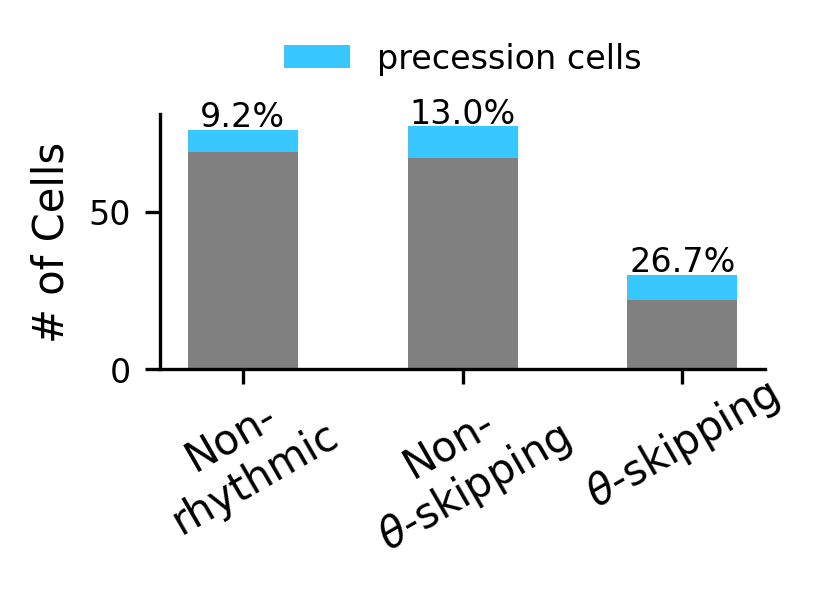

In [6]:
# ratio of pval_skip<0.05
# Create arrays for p-values
pval_skip = np.array(theta_skip_ppp)
pval_nonskip = np.array(theta_nonskip_ppp)
pval_nontheta = np.array(nontheta_ppp)

# Calculate counts for p-values less than and greater than 0.05
skip_p_less = len(pval_skip[pval_skip < 0.05])
skip_p_more = len(pval_skip[pval_skip >= 0.05])

nonskip_p_less = len(pval_nonskip[pval_nonskip < 0.05])
nonskip_p_more = len(pval_nonskip[pval_nonskip >= 0.05])

nontheta_p_less = len(pval_nontheta[pval_nontheta < 0.05])
nontheta_p_more = len(pval_nontheta[pval_nontheta >= 0.05])

# Print ratios
print('ratio of pval_skip<0.05:', skip_p_less / len(pval_skip))
print('ratio of pval_nonskip<0.05:', nonskip_p_less / len(pval_nonskip))
print('ratio of pval_nontheta<0.05:', nontheta_p_less / len(pval_nontheta))

#print the number of cells
print('nontheta HD cells:', skip_p_less, len(nontheta_ppp))
print('theta nonskip cells:', nonskip_p_less, len(theta_nonskip_ppp))
print('theta skip cells:', nontheta_p_less, len(theta_skip_ppp))

# Data for bar plot
categories = ['Non-\nrhythmic', 'Non-\n'+r'$\theta$-skipping', r'$\theta$-skipping']
less_than_005 = [nontheta_p_less, nonskip_p_less, skip_p_less]
more_than_005 = [nontheta_p_more, nonskip_p_more, skip_p_more]

# Calculate percentages
total_cells = [nontheta_p_less + nontheta_p_more, nonskip_p_less + nonskip_p_more, skip_p_less + skip_p_more]
percent_less_than_005 = [100 * less / total for less, total in zip(less_than_005, total_cells)]
percent_more_than_005 = [100 * more / total for more, total in zip(more_than_005, total_cells)]

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(2.8, 2.5), dpi=300)
labelsize = 10
ticksize = 8

bar_width = 0.5
bar1 = ax.bar(categories, more_than_005, bar_width, color='grey')
#label ha center, va center
bar2 = ax.bar(categories, less_than_005, bar_width, bottom=more_than_005, label='precession cells', color='#38c7ff')


ax.legend(frameon=False, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.4))

# Add labels and title
ax.set_ylabel('# of Cells', fontsize=labelsize)
#roatte xlabel 45 degree
ax.set_xticklabels(categories, rotation=30, ha='center', fontsize=labelsize)
#move xlabel closer to the plot
ax.tick_params(axis='x', pad=-3)

# Add percentages on top of the higher bars
for i, (less, more, total) in enumerate(zip(less_than_005, more_than_005, total_cells)):
    ax.text(i, more + less + 4, f'{percent_less_than_005[i]:.1f}%', ha='center', va='center', color='black', fontsize=ticksize)

#tickfontsize
ax.tick_params(axis='y', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


plt.savefig('./figures/phaseprecession_pval.pdf')

Statistics=3806.000, p=0.462
nontheta mean: 96.07187181901386 28.35821693221559
theta nonskip mean: 91.78194892793486 28.88573767352429
theta skip mean: 118.78115849478176 12.411568006785775
Statistics=3207.000, z=1.025, p=3.060e-01


Statistics=1813.000, z=4.564, p=5.114e-06
Statistics=1681.000, z=3.794, p=1.502e-04


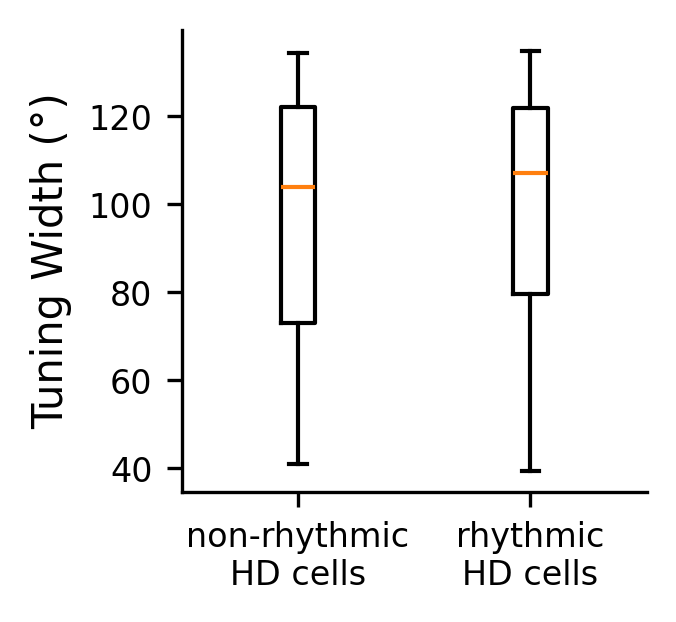

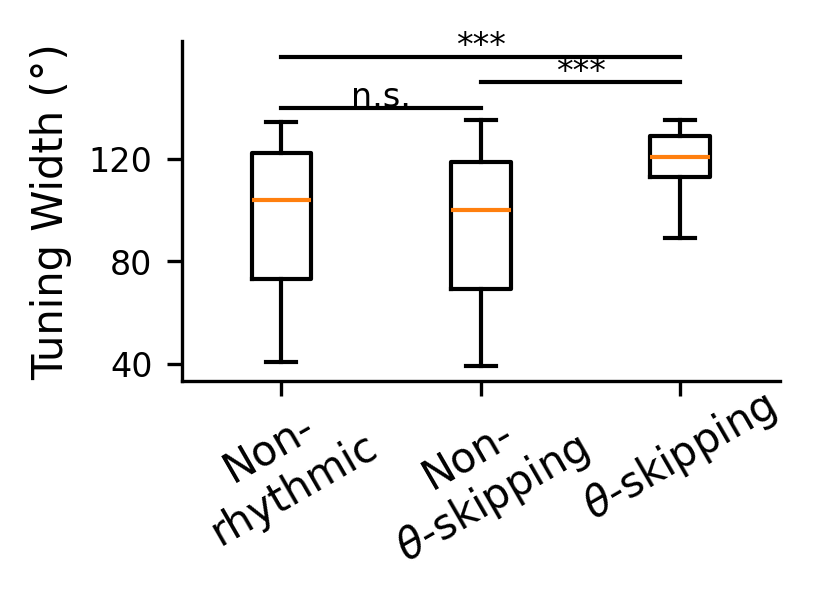

In [7]:
## Add significance lines and annotations
def add_significance_line(x1, x2, y, text, ax):
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.0)
    ax.text((x1 + x2) * .5, y+4, text, ha='center', va='center', color='black', fontsize=8)

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
labelsize = 10
ticksize = 8

ax.boxplot([nontheta_tw, theta_tw], showfliers=False)
ax.set_xticklabels(['non-rhythmic\nHD cells', 'rhythmic\nHD cells'])
ax.set_ylabel('Tuning Width (°)', fontsize=labelsize)

ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#mann-whitney u test
    
stat, p = mannwhitneyu(nontheta_tw, theta_tw)
print('Statistics=%.3f, p=%.3f' % (stat, p))

####################################################################################

fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.1), dpi=300)
labelsize = 10
ticksize = 8

ax.boxplot([nontheta_tw, theta_nonskip_tw, theta_skip_tw], showfliers=False)
ax.set_xticklabels(['Non-\nrhythmic', 'Non-\n'+r'$\theta$-skipping', r'$\theta$-skipping'], rotation=30)
ax.set_ylabel('Tuning Width (°)', fontsize=labelsize)
ax.set_yticks([0, 40, 80, 120])

#print the mean tuning width for each group
print('nontheta mean:', np.mean(nontheta_tw), np.std(nontheta_tw))
print('theta nonskip mean:', np.mean(theta_nonskip_tw), np.std(theta_nonskip_tw))
print('theta skip mean:', np.mean(theta_skip_tw), np.std(theta_skip_tw))

ax.tick_params(axis='x', which='major', labelsize=labelsize, pad = -3)
ax.tick_params(axis='y', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ylim = ax.get_ylim()

stat, p = mannwhitneyu(nontheta_tw, theta_nonskip_tw)

#cmpute z value using mannwhitneyu stat
# Calculate the Z-value
n1 = len(nontheta_tw)
n2 = len(theta_nonskip_tw)

mean_u = n1 * n2 / 2
std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z_value = (stat - mean_u) / std_u

print('Statistics=%.3f, z=%.3f, p=%.3e' % (stat, z_value, p))

if p<0.001:
    add_significance_line(1, 2, ylim[1]+0, '***', ax)
elif p<0.01:
    add_significance_line(1, 2, ylim[1]+0, '**', ax)
elif p<0.05:
    add_significance_line(1, 2, ylim[1]+0, '*', ax)
else:
    add_significance_line(1, 2, ylim[1]+0, 'n.s.', ax)
    
stat, p = mannwhitneyu(theta_skip_tw,theta_nonskip_tw)

#cmpute z valye using mannwhitneyu stat
# Calculate the Z-value
n1 = len(theta_nonskip_tw)
n2 = len(theta_skip_tw)

mean_u = n1 * n2 / 2
std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z_value = (stat - mean_u) / std_u
# print('Z-value:', z_value)
# print('Statistics=%.3f, p=%.3f' % (stat, p))
print('Statistics=%.3f, z=%.3f, p=%.3e' % (stat, z_value, p))

if p<0.001:
    add_significance_line(2, 3, ylim[1]+10, '***', ax)
elif p<0.01:
    add_significance_line(2, 3, ylim[1]+10, '**', ax)
elif p<0.05:
    add_significance_line(2, 3, ylim[1]+10, '*', ax)
else:
    add_significance_line(2, 3, ylim[1]+10, 'n.s.', ax)

stat, p = mannwhitneyu(theta_skip_tw, nontheta_tw)
#compute z value using mannwhitneyu stat
# Calculate the Z-value
n1 = len(nontheta_tw)
n2 = len(theta_skip_tw)

mean_u = n1 * n2 / 2
std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z_value = (stat - mean_u) / std_u

print('Statistics=%.3f, z=%.3f, p=%.3e' % (stat, z_value, p))

if p<0.001:
    add_significance_line(1, 3, ylim[1]+20, '***', ax)
elif p<0.01:
    add_significance_line(1, 3, ylim[1]+20, '**', ax)
elif p<0.05:
    add_significance_line(1, 3, ylim[1]+20, '*', ax)
else:
    add_significance_line(1, 3, ylim[1]+20, 'n.s.', ax)

#doing the stats for each pairs

plt.tight_layout()

plt.savefig('./figures/tuning_width.pdf')

### plot example HD cells with/without theta modulation


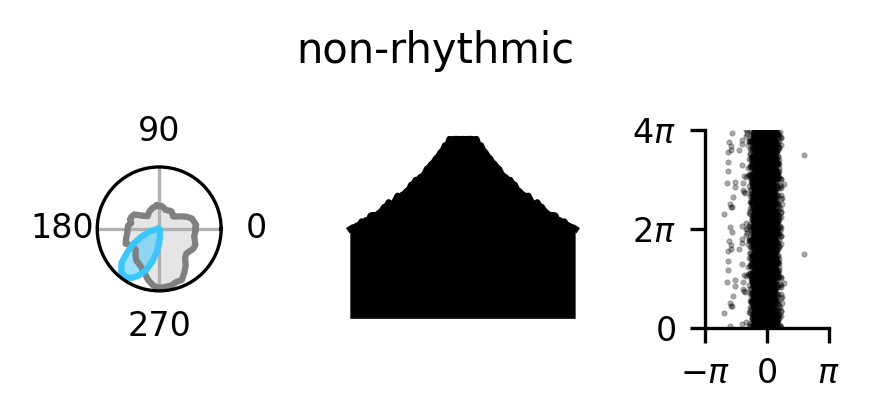

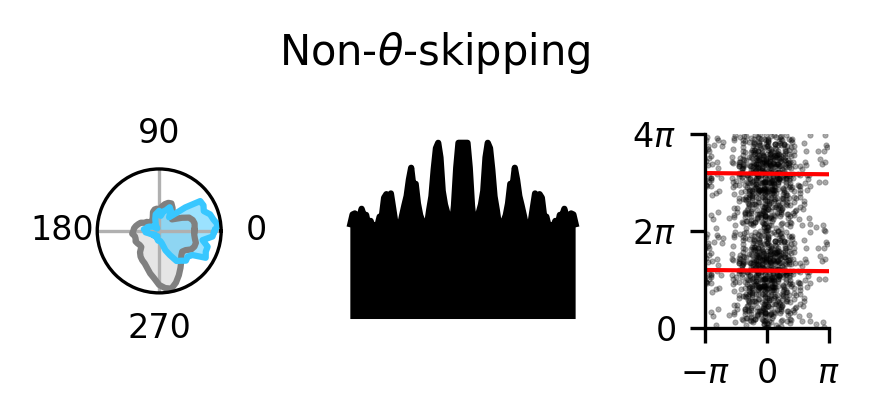

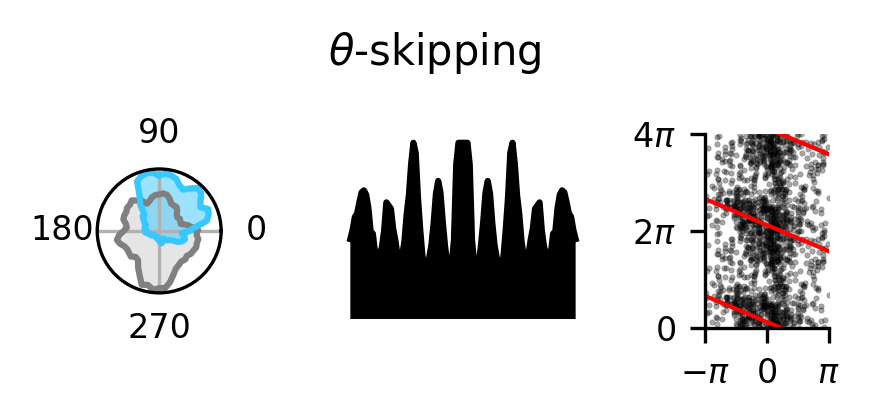

In [8]:
def plot_example_hdtuning_and_theta(fig, cell_name, matnames, config, cell_type, addfitline=True):

    ratname, file_path = matnames[cell_name]
    data_dict = load_data(ratname, file_path)
    cell_data = data_dict['cells_data'][cell_name]


    pot = data_dict['pot'].flatten()
    poh = data_dict['poh'] 
    
    #interpolte pot 
    sampling_interval = np.diff(pot).mean()
    new_interval = sampling_interval / config['interpolation_factor']
    pot_interp = np.arange(0, pot[-1], new_interval)

    gs=fig.add_gridspec(1, 3, width_ratios=[1, 2, 1])

    psph = cell_data['psph'].flatten()
    pspt = cell_data['pspt'].flatten()
    spike_phase = cell_data['spike_phase'].flatten()
    hd_mean = cell_data['hd_mean'][0][0]

    ax0 = fig.add_subplot(gs[0, 0], projection='polar')

    plot_head_direction_tuning(ax0, poh, psph, config)

    ax1 = fig.add_subplot(gs[0, 1])
    #calculate autocorrelation of spike in [-500, 500] ms, each bin is 20 ms
    spike_array = compute_spike_array(pspt, pot_interp)
    autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5)
    plot_autocorrelogram(ax1, autocorrelogram2, cell_type='')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3, _ = plot_phaseprecession(ax3, poh, pot, pspt, psph, hd_mean, spike_phase, config, addfitline=addfitline)
    # ax3.set_ylabel('Spike Phase', fontsize=8)
    # ax3.set_xlabel('Head Direction', fontsize=8)

    for ax in [ax0, ax1, ax3]:
        #tickfontsize
        ax.tick_params(axis='both', which='major', labelsize=8)
        if ax == ax0:
            #move ticks clloser to the plot
            ax.tick_params(axis='x', pad=-2)
    
    #suptitle
    fig.suptitle(cell_type, fontsize=10, y=0.9)
    
    plt.tight_layout()    
    
    return fig

config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 2, 
    'interpolation_factor': 2 #1 is 0.02s, and 2 is 0.01s
}


#a non-theta modulated HD cell
figsize = (3, 1.5)
cell_name = 'rR448_15042020_t2_c1'
fig = plt.figure(figsize=figsize, dpi=300)
plot_example_hdtuning_and_theta(fig, cell_name, matnames, config, cell_type='non-rhythmic', addfitline=False)
plt.savefig('./figures/' + cell_name + '.pdf', dpi=300)

#a theta-modulated HD cell without theta skipping

cell_name = 'rR449_27032020_t4_c2'
fig = plt.figure(figsize=figsize, dpi=300)
plot_example_hdtuning_and_theta(fig, cell_name, matnames, config, cell_type=r'Non-'+r'$\theta$-skipping', addfitline=True)
plt.savefig('./figures/' + cell_name + '.pdf', dpi=300)

#a theta-modulated HD cell with theta skipping
cell_name = 'rR651_26062019_t1_c1'
fig = plt.figure(figsize=figsize, dpi=300)
plot_example_hdtuning_and_theta(fig, cell_name, matnames, config, cell_type=r'$\theta$-skipping', addfitline=True)
plt.savefig('./figures/' + cell_name + '.pdf', dpi=300)

### delete phase precession and plot only theta modulation (as reviewer suggested)

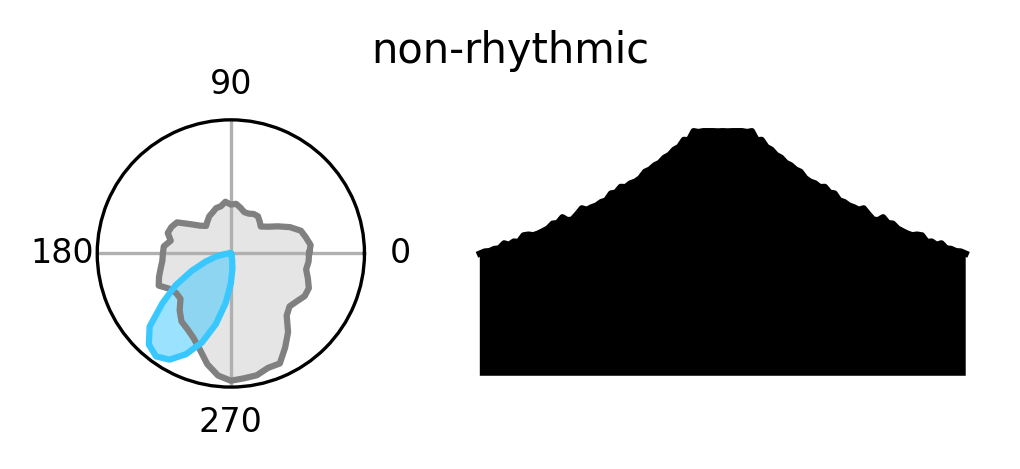

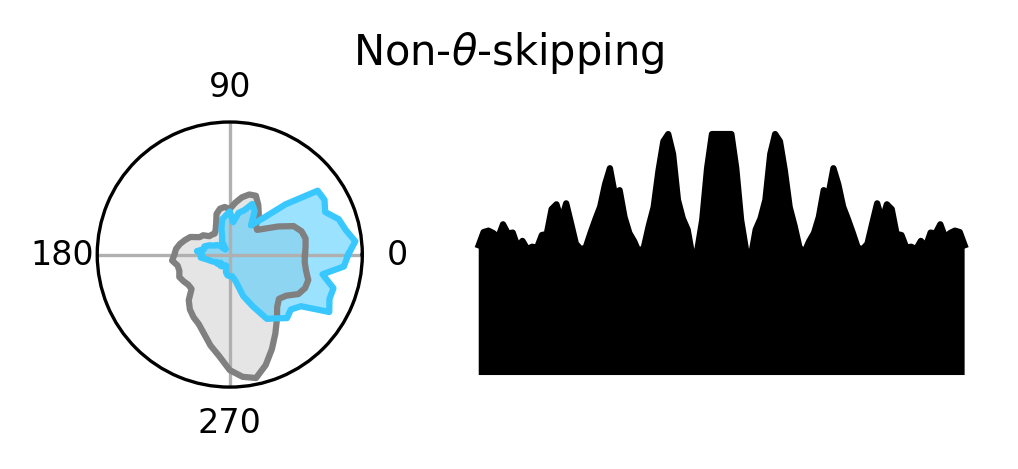

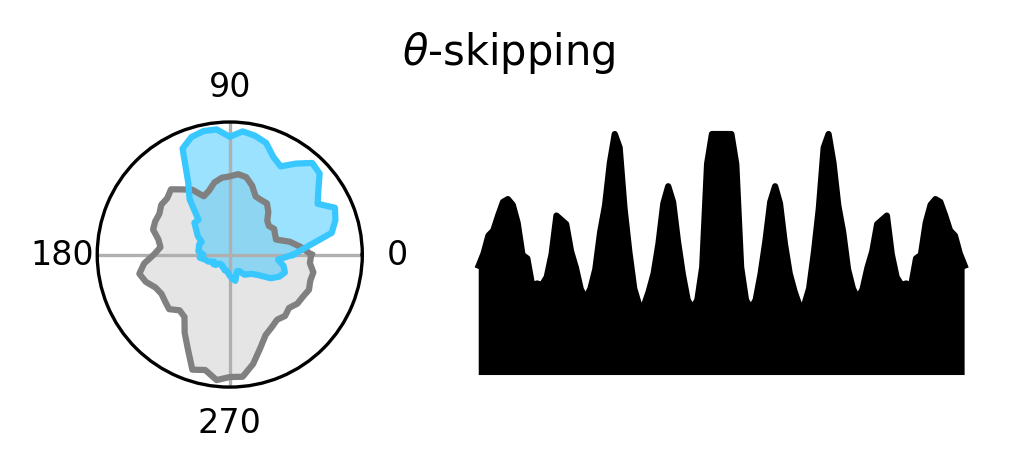

In [16]:
def plot_example_hdtuning_and_theta_only(fig, cell_name, matnames, config, cell_type, addfitline=True):
    
    ratname, file_path = matnames[cell_name]
    data_dict = load_data(ratname, file_path)
    cell_data = data_dict['cells_data'][cell_name]


    pot = data_dict['pot'].flatten()
    poh = data_dict['poh'] 
    
    #interpolte pot 
    sampling_interval = np.diff(pot).mean()
    new_interval = sampling_interval / config['interpolation_factor']
    pot_interp = np.arange(0, pot[-1], new_interval)

    gs=fig.add_gridspec(1, 2, width_ratios=[1, 2])

    psph = cell_data['psph'].flatten()
    pspt = cell_data['pspt'].flatten()
    spike_phase = cell_data['spike_phase'].flatten()
    hd_mean = cell_data['hd_mean'][0][0]

    ax0 = fig.add_subplot(gs[0, 0], projection='polar')

    plot_head_direction_tuning(ax0, poh, psph, config)

    ax1 = fig.add_subplot(gs[0, 1])
    #calculate autocorrelation of spike in [-500, 500] ms, each bin is 20 ms
    spike_array = compute_spike_array(pspt, pot_interp)
    autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5)
    plot_autocorrelogram(ax1, autocorrelogram2, cell_type='')

    for ax in [ax0, ax1]:
        #tickfontsize
        ax.tick_params(axis='both', which='major', labelsize=8)
        if ax == ax0:
            #move ticks clloser to the plot
            ax.tick_params(axis='x', pad=-2)
    
    #suptitle
    fig.suptitle(cell_type, fontsize=10, y=0.9)
    
    plt.tight_layout()    
    
    return fig

config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 2, 
    'interpolation_factor': 2 #1 is 0.02s, and 2 is 0.01s
}


#a non-theta modulated HD cell
figsize = (3.5, 1.5)
cell_name = 'rR448_15042020_t2_c1'
fig = plt.figure(figsize=figsize, dpi=300)
plot_example_hdtuning_and_theta_only(fig, cell_name, matnames, config, cell_type='non-rhythmic', addfitline=False)
plt.savefig('./figures/' + cell_name + '_autocorrelogram.pdf', dpi=300)

#a theta-modulated HD cell without theta skipping

cell_name = 'rR449_27032020_t4_c2'
fig = plt.figure(figsize=figsize, dpi=300)
plot_example_hdtuning_and_theta_only(fig, cell_name, matnames, config, cell_type='Non-'+r'$\theta$-skipping', addfitline=True)
plt.savefig('./figures/' + cell_name + '_autocorrelogram.pdf', dpi=300)

#a theta-modulated HD cell with theta skipping
cell_name = 'rR651_26062019_t1_c1'
fig = plt.figure(figsize=figsize, dpi=300)
plot_example_hdtuning_and_theta_only(fig, cell_name, matnames, config, cell_type=r'$\theta$-skipping', addfitline=True)
plt.savefig('./figures/' + cell_name + '_autocorrelogram.pdf', dpi=300)

In [10]:
0.8/np.pi/2

0.12732395447351627